In [138]:
import matplotlib as mpl
from matplotlib import pyplot as plt

# define matplotlib style
plt.style.use("classic")
mpl.rc("xtick", labelsize=23)
mpl.rc("ytick", labelsize=23)
mpl.rc("xtick.major", size=15, width=2)
mpl.rc("xtick.minor", size=8, width=2, visible=True)
mpl.rc("ytick.major", size=15, width=2)
mpl.rc("ytick.minor", size=8, width=2, visible=True)
mpl.rc("lines", linewidth=3, markersize=20)
mpl.rc("axes", linewidth=2, labelsize=30, labelpad=2.5)
mpl.rc("legend", fontsize=25, loc="best", frameon=False, numpoints=1)

mpl.rc("font", family="STIXGeneral")
mpl.rc("mathtext", fontset="stix")

In [139]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator
from tqdm import tqdm

In [140]:
from tidaldisruptionlrd import stellar_distribution, tde_rate
from tidaldisruptionlrd.constants import G

In [141]:
import importlib

importlib.reload(stellar_distribution)
importlib.reload(tde_rate)

<module 'tidaldisruptionlrd.tde_rate' from '/Users/vinhtran/Data/Research/Mark/LRD Tidal Disruption/TidalDisruptionLRD/src/tidaldisruptionlrd/tde_rate.py'>

In [142]:
class HernquistTDEGrid:
    def __init__(self, M_bhs, M_s_scalers, sigma=None):
        self.M_bhs = M_bhs
        self.M_s_scalers = M_s_scalers

        self.sigma = sigma or self._get_sigma(M_bhs)

        _N_TDEs = []
        for _M_s_scaler in tqdm(self.M_s_scalers):
            _N_TDEs.append(self._get_single_TDE_rates(_M_s_scaler))  # noqa: PERF401

        self.N_TDEs = np.vstack(_N_TDEs)

    def _get_sigma(self, M_bh, M200=10**8.32, p=5.64):
        return 200 * (M_bh / M200) ** (1 / p)

    def _get_single_TDE_rates(self, M_s_scaler):
        _profile = stellar_distribution.HernquistProfile(
            M_s_scaler,
            r_bin_min=1e-4,
            r_bin_max=1e6,
            N_bins=1000,
            reduce_factor=10,
            N_trapz_bins=100,
            show_progress=False,
        )

        _as = 0.2**2 * G * self.M_bhs * _profile.M_s / self.sigma**2
        _r_hs = _as / _profile.a
        # _r_hs = np.full_like(self.M_bhs, 0.055 / _profile.a)

        _tde = tde_rate.SalpeterTDERate(
            dimensionless_profile=_profile,
            M_bhs=self.M_bhs,
            r_hs=_r_hs,
            m_s_bins=np.linspace(0.08, 2, 1000),
            eta=0.844,
            show_progress=False,
        )

        return _tde.N_TDEs

In [143]:
hernquist_tde = HernquistTDEGrid(
    M_bhs=np.logspace(6, 10, 100),
    M_s_scalers=np.logspace(0, 6, 50),
    # sigma=100,
)

100%|██████████| 50/50 [04:56<00:00,  5.93s/it]


In [171]:
interpolator = RegularGridInterpolator(
    (np.log10(hernquist_tde.M_s_scalers), np.log10(hernquist_tde.M_bhs)),
    np.log10(hernquist_tde.N_TDEs).reshape(
        len(hernquist_tde.M_s_scalers), len(hernquist_tde.M_bhs)
    ),
    bounds_error=False,
    fill_value=np.nan,
)

M_bh = np.logspace(6, 10, 200)
M_s = np.logspace(8, 12, 150)

M_s_grid, M_bh_grid = np.meshgrid(M_s, M_bh, indexing="ij")

M_s_scaler_grid = M_s_grid / M_bh_grid

log10_N_TDE_grid = interpolator(
    (np.log10(M_s_scaler_grid.flatten()), np.log10(M_bh_grid.flatten()))
).reshape(M_s_grid.shape)

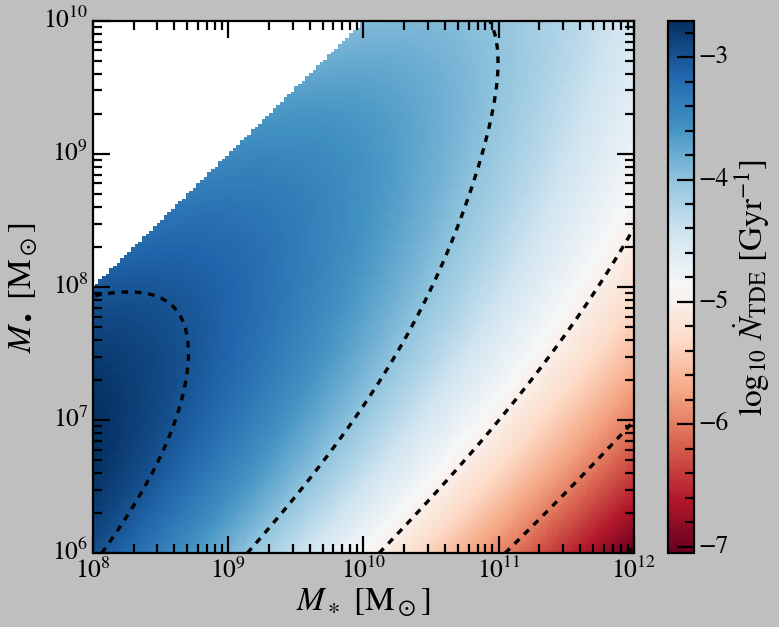

In [174]:
fig, ax = plt.subplots(figsize=(10, 8))

c = ax.pcolormesh(
    M_s,
    M_bh,
    log10_N_TDE_grid.T,
    # vmin=-6.25, vmax=-2.75,
    cmap="RdBu",
    shading="auto",
)
cb = fig.colorbar(c, ax=ax, label=r"$\log_{10} \, \dot{N}_{\rm TDE}$ [Gyr$^{-1}$]")

# for scaleing in [1, 10, 100, 1000]:
#     ax.plot(M_bh*scaleing, M_bh, "k--")

levels = np.arange(-7, 2)

cont = ax.contour(
    M_s,
    M_bh,
    log10_N_TDE_grid.T,
    levels=levels,
    colors="k",
)

# ax.clabel(cont, inline=False, fontsize=25, fmt="$10^{%i}$")

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlim(1e8, 1e12)
ax.set_ylim(1e6, 1e10)

ax.set_xlabel(r"$M_\ast$ [M$_\odot$]")
ax.set_ylabel(r"$M_\bullet$ [M$_\odot$]")

plt.tight_layout()
plt.show()